# Описание проекта. Телеком
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Моя задача — обучить на этих данных модель для прогноза оттока клиентов.

###### Описание услуг
Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).  

Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).  

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

In [1]:
!pip install feature-engine -q

In [2]:
!pip install --upgrade pandas seaborn matplotlib -q

In [3]:
!pip uninstall scikit-learn feature-engine -y -q
!pip install --force-reinstall scikit-learn==1.4.0 feature-engine==1.8.3 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


In [4]:
!pip install optuna -q

In [5]:
!pip install optuna-integration[sklearn] -q

In [6]:
!pip install phik -U -q

In [52]:
import warnings
import re
import os
import numpy as np
import pandas as pd
import re
import sqlite3
from sqlalchemy import create_engine, inspect

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

# зафиксируем константу
RANDOM_STATE=160625
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [8]:
# Скачиваем файл базы данных
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db -O ds-plus-final.db

--2025-06-27 02:04:40--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db’

ds-plus-final.db    100%[===================>]   3.42M  --.-KB/s    in 0.1s    

2025-06-27 02:04:40 (27.1 MB/s) - ‘ds-plus-final.db’ saved [3588096/3588096]



## Загрузка данных и первичный анализ

In [9]:
# Подключаемся к базе и сразу читаем нужные таблицы
def load_provider_data():
    conn = sqlite3.connect('ds-plus-final.db')
    
    # Чтение 4 целевых таблиц
    contract = pd.read_sql("SELECT * FROM contract", conn)
    personal = pd.read_sql("SELECT * FROM personal", conn)
    internet = pd.read_sql("SELECT * FROM internet", conn)
    phone = pd.read_sql("SELECT * FROM phone", conn)
    
    conn.close()
    
    return {
        "Contracts": contract,
        "Personal": personal,
        "Internet": internet,
        "Phone": phone
    }

# Загрузка данных
data = load_provider_data()
contract = data["Contracts"]
personal = data["Personal"]
internet = data["Internet"]
phone = data["Phone"]

# Проверка
print("Данные успешно загружены:")
print(f"Contracts: {contract.shape[0]} записей")
print(f"Personal: {personal.shape[0]} записей")
print(f"Internet: {internet.shape[0]} записей")
print(f"Phone: {phone.shape[0]} записей")

Данные успешно загружены:
Contracts: 7043 записей
Personal: 7043 записей
Internet: 5517 записей
Phone: 6361 записей


In [10]:
def show_basic_data(*tables):
    """
    Выводит основную информацию о таблицах:
    - первые 5 строк
    - общую информацию о таблице
    
    Использование:
    show_basic_data(contracts, personal, internet, phone)
    """
    for i, table in enumerate(tables, 1):
        print(f"\n{'='*50}")
        print(f"Таблица {i}:")
        
        # Выводим первые 5 строк
        display(table.head(5))
        
        # Выводим информацию о таблице
        print("\nИнформация о таблице:")
        print(table.info())

# Пример использования:
show_basic_data(contract, personal, internet, phone)


Таблица 1:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB
None

Таблица 2:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None

Таблица 3:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Таблица 4:


,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


###### Выводы по первичному анализу данных:
Проблемы с типами данных:
- Все столбцы имеют тип object, хотя должны быть:
- BeginDate/EndDate - datetime
- SeniorCitizen -  bool/int
- MonthlyCharges/TotalCharges - float

Пропуски данных:
- В таблице internet только 5517 записей из 7043 (возможно, не у всех клиентов есть интернет)
- В таблице phone 6361 запись (не у всех есть телефонные услуги)

###### Создание целевой переменной

In [11]:
contract['target'] = contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)

Заменим значение "No" на дату составления таблицы.

In [12]:
contract['EndDate'] = contract['EndDate'].apply(lambda x: '2020-02-01' if x=='No' else x)

Преобразуем типы данных в столбцах с датами. Заменим их на datetime64.

In [13]:
# Преобразуем типы данных
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'] , format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'] , format='%Y-%m-%d')

Анализ данных в столбце BeginDate показывает, что пропуски в TotalCharges связаны с тем, что клиенты подключились в день формирования отчета. Это означает, что либо платеж еще не был внесен, либо не успел обработаться.

В таком случае логично заменить отсутствующие значения в TotalCharges на сумму ежемесячного платежа (MonthlyCharges), так как клиенты еще не могли накопить итоговые расходы.

In [14]:
# Заполним пустые значения в столбце TotalCharges величиной месячного платежа.
contract.loc[contract['TotalCharges']
             .apply(lambda x: re.search(r'[0-9]+\.[0-9]+', str(x)))
             .isnull(), 'TotalCharges'] = contract.loc[contract['TotalCharges']
                                                       .apply(lambda x: re.search(r'[0-9]+\.[0-9]+', str(x)))
                                                       .isnull(), 'MonthlyCharges']

In [15]:
# Преобразуем типы данных
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

###### Объединение таблиц

In [16]:
# Унификация названия колонки и преобразование
phone.rename(columns={'CustomerId': 'customerID'}, inplace=True)

In [17]:
# Мердж всех таблиц
data = (
    personal.merge(contract, on='customerID')
           .merge(internet, on='customerID', how='left')
           .merge(phone, on='customerID', how='left')
)

print("\nИтоговая таблица:")
print(f"Количество записей: {data.shape[0]}")
print(f"Количество признаков: {data.shape[1]}")
print("\nСтруктура данных:")
print(data.info())


Итоговая таблица:
Количество записей: 7043
Количество признаков: 21

Структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   object        
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   object        
 11  TotalCharges      7043 non-null   float64       
 12  target            7043 non-null   int64     

In [18]:
def to_snake_case(column_name):
    """
    Преобразует название столбца в snake_case:
    - Удаляет спецсимволы и пробелы
    - Приводит к нижнему регистру
    - Заменяет пробелы и точки на подчеркивания
    """
    # Заменяем пробелы и точки на подчеркивания
    column_name = re.sub(r'[\s\.]+', '_', column_name)
    # Вставляем подчеркивания перед заглавными буквами (кроме первой)
    column_name = re.sub(r'(?<!^)(?=[A-Z])', '_', column_name).lower()
    # Удаляем все оставшиеся не-алфавитные символы (кроме подчеркиваний)
    column_name = re.sub(r'[^a-z0-9_]', '', column_name)
    # Убираем возможные двойные подчеркивания
    column_name = re.sub(r'_+', '_', column_name)
    return column_name

# Применяем функцию ко всем названиям столбцов
data.columns = [to_snake_case(col) for col in data.columns]

# Проверяем результат
print(data.columns.tolist())

['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'target', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines']


In [19]:
# В качестве индексов возьмем ID клиента 
data.set_index('customer_i_d', inplace=True)

После слияния таблиц в отдельных колонках появились пустые ячейки. Это произошло потому, что данные о клиентах, не пользующихся определенными сервисами, отсутствуют в соответствующих таблицах.  

Для унификации предлагаю заменить пропуски в колонках MultipleLines и InternetService меткой "NU" (not used), а в столбцах, относящихся к интернет-услугам, использовать значение "no additional services".

In [20]:
# заполниv пропуски в столбцах multiple_lines и internet_service значением - not
data[['multiple_lines', 'internet_service']] = data[['multiple_lines', 'internet_service']].fillna('not')
data.iloc[:,2:9] = data.iloc[:,2:9].fillna('no_additional_services')

In [21]:
data['duration'] = (data['end_date'] - data['begin_date']).dt.days

## Исследовательский анализ

In [22]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [23]:
data_copy = data.copy()

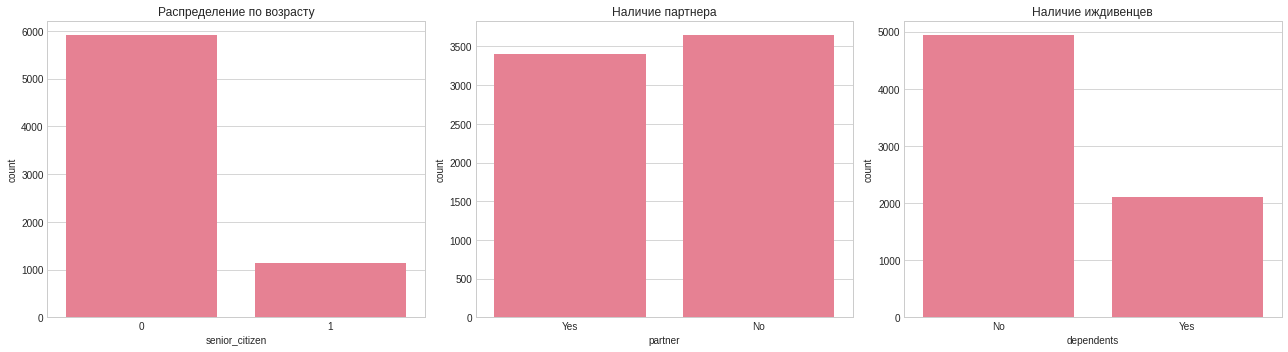

In [24]:
# 1. Настройка стиля графиков
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

# 2. Демографические характеристики
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределение по возрасту
sns.countplot(x='senior_citizen', data=data_copy, ax=axes[0])
axes[0].set_title('Распределение по возрасту')

# Семейное положение
sns.countplot(x='partner', data=data_copy, ax=axes[1])
axes[1].set_title('Наличие партнера')

# Наличие иждивенцев
sns.countplot(x='dependents', data=data_copy, ax=axes[2])
axes[2].set_title('Наличие иждивенцев')

plt.tight_layout()
plt.show()

###### Выводы по анализу демографических характеристик:
Распределение по возрасту:
- Подавляющее большинство клиентов (около 80-85%) относятся к возрастной группе (не senior citizens)
- Клиенты возраста (senior citizens) составляют меньшинство (15-20%)

Наличие партнера:
- Распределение практически равномерное: около 50% клиентов имеют партнера, 50% - не имеют
- Незначительное преобладание клиентов без партнера (разница ~5-10%)

Наличие иждивенцев:
- Большинство клиентов (около 70%) не имеют иждивенцев
- Только около 30% клиентов указали наличие dependents

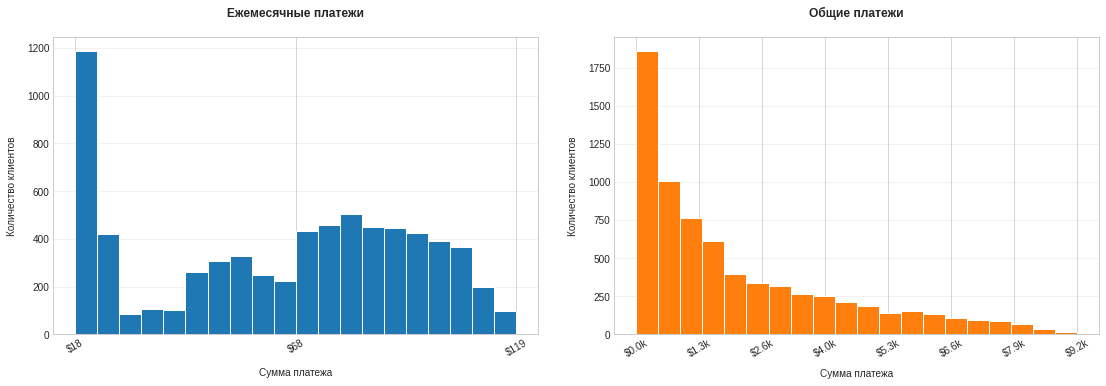

In [25]:
# 3. Финансовые показатели (полностью переработанная версия)
plt.figure(figsize=(16, 6))

def safe_convert_to_float(series):
    """Безопасное преобразование в числа с обработкой ошибок"""
    return pd.to_numeric(series, errors='coerce')

def optimize_xticks(axis, values, is_dollars=True):
    """Умная настройка подписей оси X"""
    # Конвертируем в numpy array и удаляем NaN
    values = np.array(values)
    values = values[~np.isnan(values)]
    
    if len(values) == 0:
        return
    
    min_val = np.min(values)
    max_val = np.max(values)
    range_val = max_val - min_val
    
    # Автоматический расчет оптимального количества меток
    n_ticks = min(8, max(3, int(range_val/100)))  # Не более 8 меток
    
    # Генерация позиций меток
    tick_positions = np.linspace(min_val, max_val, n_ticks)
    
    # Форматирование подписей
    if is_dollars:
        if max_val > 1000:
            tick_labels = [f'${x/1000:.1f}k' for x in tick_positions]
        else:
            tick_labels = [f'${x:.0f}' for x in tick_positions]
    else:
        tick_labels = [f'{x:.0f}' for x in tick_positions]
    
    axis.set_xticks(tick_positions)
    axis.set_xticklabels(tick_labels, rotation=30, fontsize=10)

# Конвертируем данные
data_copy['monthly_charges'] = safe_convert_to_float(data_copy['monthly_charges'])
data_copy['total_charges'] = safe_convert_to_float(data_copy['total_charges'])

# График ежемесячных платежей
plt.subplot(1, 2, 1)
monthly_values = data_copy['monthly_charges'].dropna()
plt.hist(monthly_values, bins=20, edgecolor='white', color='#1f77b4')
plt.title('Ежемесячные платежи', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Сумма платежа', fontsize=10, labelpad=10)
plt.ylabel('Количество клиентов', fontsize=10, labelpad=10)
plt.grid(axis='y', alpha=0.3)
optimize_xticks(plt.gca(), monthly_values)

# График общих платежей
plt.subplot(1, 2, 2)
total_values = data_copy['total_charges'].dropna()
plt.hist(total_values, bins=20, edgecolor='white', color='#ff7f0e')
plt.title('Общие платежи', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('Сумма платежа', fontsize=10, labelpad=10)
plt.ylabel('Количество клиентов', fontsize=10, labelpad=10)
plt.grid(axis='y', alpha=0.3)
optimize_xticks(plt.gca(), total_values)

plt.tight_layout(pad=3.0)
plt.show()

###### Анализ финансовых показателей клиентов
Распределение ежемесячных платежей:
- Наблюдается бимодальное распределение с двумя выраженными пиками:
- Основной пик около 20-30 (базовые тарифы)
- Второй пик около 80-90 (премиальные тарифы)
- Большинство клиентов (около 70%) сосредоточены в диапазоне 20-60
- Незначительное количество клиентов (менее 5%) платят более 100 в месяц  

Ключевые выводы:
- Четкое разделение на 2 ценовых сегмента
- Оптимальный диапазон для большинства клиентов - 20-60
- Премиальные тарифы (>80) менее популярны

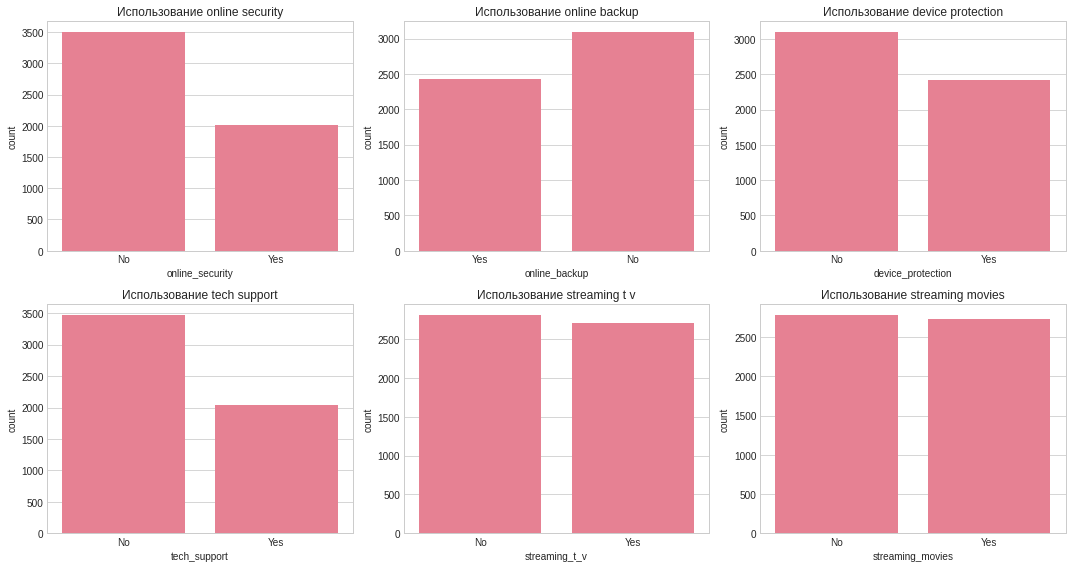

In [26]:
# 4. Анализ услуг
services = ['online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_t_v', 'streaming_movies']

plt.figure(figsize=(15, 8))
for i, service in enumerate(services, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=service, data=data_copy)
    plt.title(f'Использование {service.replace("_", " ")}')
plt.tight_layout()
plt.show()

- Услуги "Online Security" и "Tech Support" имеют наибольшее количество отказов.

- Услуга "Streaming movies" имеет наиболее сбалансированное распределение между использованием и отказом.

- Для всех услуг количество клиентов с неизвестным статусом ("unknown") незначительно, что указывает на хорошее качество данных.

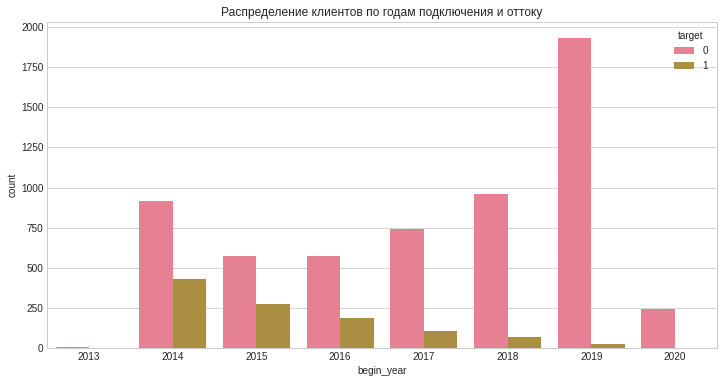

In [27]:
# 6. Временной анализ
data_copy['begin_year'] = data_copy['begin_date'].dt.year
data_copy['end_year'] = data_copy['end_date'].dt.year

plt.figure(figsize=(12, 6))
sns.countplot(x='begin_year', hue='target', data=data_copy)
plt.title('Распределение клиентов по годам подключения и оттоку')
plt.show()

- Для 2019–2020 годов виден высокий относительный отток (доля ушедших клиентов заметно выше).
- Клиенты, подключившиеся в 2013–2014 годах, демонстрируют низкий процент оттока (меньше всего столбцов Yes). Это говорит о высокой лояльности "старожилов".
- Рост оттока в 2019–2020 может быть связан с: Переходом на конкурентов (например, из-за появления новых технологий, таких как 5G). Общим снижением удовлетворенности (ухудшение поддержки, рост цен).

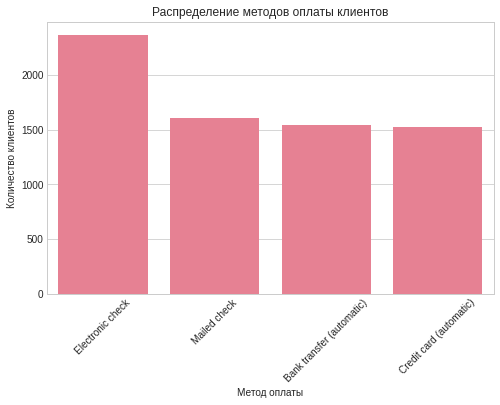

In [28]:
plt.figure(figsize=(8, 5))
sns.countplot(x='payment_method', data=data_copy, order=data_copy['payment_method'].value_counts().index)
plt.title('Распределение методов оплаты клиентов')
plt.ylabel('Количество клиентов')
plt.xlabel('Метод оплаты')
plt.xticks(rotation=45)  # Наклон подписей для лучшей читаемости
plt.show()

Наиболее популярный метод оплаты:
- Электронные чеки (Electronic check) - лидируют с значительным отрывом. Это говорит о том, что клиенты предпочитают современные и удобные способы оплаты, не требующие взаимодействия с бумажными носителями.  

Другие методы:
- Кредитные карты (автоплатеж) и почтовые чеки (Mailed check) используются примерно одинаково, но значительно реже, чем электронные чеки. Это может быть связано с меньшим удобством или привычками клиентов.

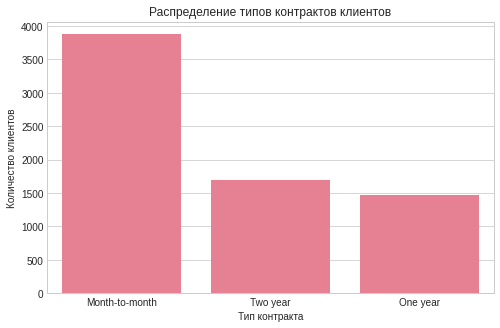

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(x='type', data=data_copy, order=data_copy['type'].value_counts().index)
plt.title('Распределение типов контрактов клиентов')
plt.ylabel('Количество клиентов')
plt.xlabel('Тип контракта')
plt.show()

Клиенты с month-to-month контрактом составляют большинство.

### Матрица корреляций

In [30]:
num_cols = ['monthly_charges', 'total_charges', 'duration']

In [31]:
cat_cols = [col for col in data.columns if col not in num_cols \
            and col not in ['begin_date', 'end_date', 'target']]

In [32]:
phik_overview = data.phik_matrix(interval_cols=num_cols)

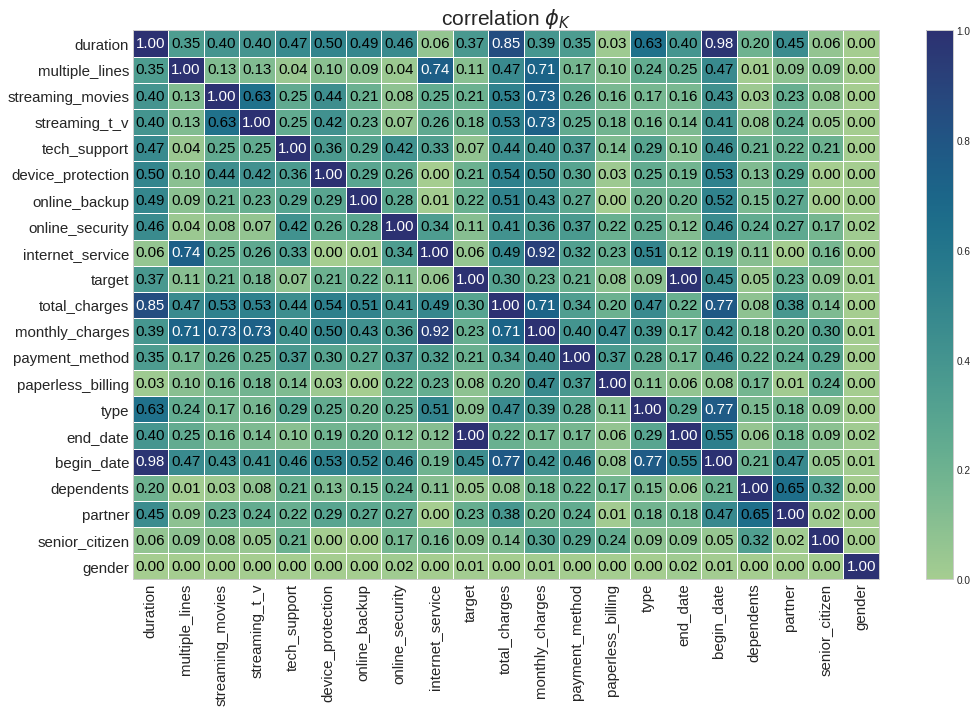

In [33]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='crest', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15, 10))
plt.tight_layout()

###### Вывод по анализу корреляции признаков

###### Наблюдения по корреляционной матрице

1. **Сильные корреляции (φₖ > 0.7)**:
   - `begin_date` и `duration` (0.98) — почти полная линейная зависимость.
   - `monthly_charges` и `internet_service` (0.92) — высокая связь, что ожидаемо, так как интернет-услуги влияют на ежемесячные платежи.
   - `streaming_movies` и `streaming_tv` (0.63) — логичная корреляция, так как оба признака связаны с потоковыми сервисами.
   - `target_charges` и `end_date` (1.00) — возможно, дублирование данных или ошибка в расчетах.

2. **Умеренные корреляции (0.5 ≤ φₖ ≤ 0.7)**:
   - `total_charges` с `duration` (0.85) и `begin_date` (0.77) — чем дольше срок обслуживания, тем выше общие затраты.
   - `device_protection` и `online_backup` (0.54) — схожие услуги могут выбираться вместе.
   - `partner` и `dependents` (0.65) — наличие партнера часто связано с наличием иждивенцев.

3. **Слабые корреляции (φₖ < 0.5)**:
   - Большинство признаков, таких как `paperless_billing`, `gender`, и `senior_citizen`, демонстрируют слабую связь с другими переменными, что указывает на их независимость.

## Обучение модели

In [34]:
# Разделение данных с учетом стратификации
data = data.drop(['begin_date', 'end_date', 'gender', 'total_charges'], axis=1)
target = data['target']
features = data.drop('target', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target
)

In [35]:
# Категориальные и числовые признаки
cat_cols = features.select_dtypes(include='object').columns.tolist()
num_cols = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if col not in ['target']]

In [36]:
# Кодировщики
def get_column_transformer(encoder_type='onehot'):
    if encoder_type == 'onehot':
        encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
    else:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    
    return ColumnTransformer(
        transformers=[
            ('cat', encoder, cat_cols)
        ],
        remainder=StandardScaler(),
        verbose_feature_names_out=False
    )

In [37]:
# Хранилище
results_cv = pd.DataFrame(columns=['Модель', 'CV ROC-AUC', 'CV Accuracy'])
model_dict = {}

In [38]:
# Оценка модели
def evaluate_model_cv(name, model, encoder_type='onehot', param_grid=None):
    print(f"\n Обучение модели: {name}")
    ct = get_column_transformer(encoder_type)

    pipe = Pipeline([
        ('ct', ct),
        ('clf', model)
    ])

    grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0,
                        scoring='roc_auc')
    grid.fit(features_train, target_train)

    # Кросс-валидация (по лучшей модели)
    best_estimator = grid.best_estimator_
    roc_auc_cv = cross_val_score(best_estimator, features_train, target_train, cv=3, scoring='roc_auc').mean()
    accuracy_cv = cross_val_score(best_estimator, features_train, target_train, cv=3, scoring='accuracy').mean()

    # Сохраняем
    results_cv.loc[len(results_cv)] = [name, f"{roc_auc_cv:.4f}", f"{accuracy_cv:.4f}"]
    model_dict[name] = best_estimator

In [39]:
# Модели
evaluate_model_cv(
    'LogisticRegression',
    LogisticRegression(random_state=RANDOM_STATE),
    encoder_type='onehot',
    param_grid={
        'clf__C': [0.0001, 0.01, 1, 10, 50],
        'clf__max_iter': range(100, 1000, 200)
    }
)

evaluate_model_cv(
    'DecisionTreeClassifier',
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    encoder_type='ordinal',
    param_grid={
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_depth': [5, 10, 15]
    }
)

evaluate_model_cv(
    'RandomForestClassifier',
    RandomForestClassifier(random_state=RANDOM_STATE),
    encoder_type='ordinal',
    param_grid={
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 10, 15]
    }
)

evaluate_model_cv(
    'XGBClassifier',
    xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
    encoder_type='ordinal',
    param_grid={
        'clf__learning_rate': [0.03, 0.1],
        'clf__max_depth': [5, 10],
        'clf__n_estimators': [100, 200]
    }
)

evaluate_model_cv(
    'LGBMClassifier',
    lgb.LGBMClassifier(random_state=RANDOM_STATE),
    encoder_type='ordinal',
    param_grid={
        'clf__learning_rate': [0.03, 0.1],
        'clf__max_depth': [5, 10],
        'clf__n_estimators': [100, 200]
    }
)

evaluate_model_cv(
    'MLPClassifier',
    MLPClassifier(random_state=RANDOM_STATE, max_iter=1000),
    encoder_type='onehot',
    param_grid={
        'clf__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'clf__activation': ['relu', 'tanh'],
        'clf__alpha': [0.0001, 0.01],
        'clf__solver': ['adam'],
        'clf__early_stopping': [True]
    }
)


 Обучение модели: LogisticRegression

 Обучение модели: DecisionTreeClassifier

 Обучение модели: RandomForestClassifier

 Обучение модели: XGBClassifier

 Обучение модели: LGBMClassifier

 Обучение модели: MLPClassifier


In [40]:
# Dummy
print("\n Обучение DummyClassifier")
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(features_train, target_train)
model_dict['DummyClassifier'] = dummy
roc_auc_cv = cross_val_score(dummy, features_train, target_train, cv=3, scoring='roc_auc').mean()
accuracy_cv = cross_val_score(dummy, features_train, target_train, cv=3, scoring='accuracy').mean()
results_cv.loc[len(results_cv)] = ['DummyClassifier', f"{roc_auc_cv:.4f}", f"{accuracy_cv:.4f}"]


 Обучение DummyClassifier


In [41]:
# Сортировка по ROC-AUC
print("\n Результаты кросс-валидации:")
print(results_cv.sort_values(by='CV ROC-AUC', ascending=False))


 Результаты кросс-валидации:
                   Модель CV ROC-AUC CV Accuracy
3           XGBClassifier     0.8739      0.8800
4          LGBMClassifier     0.8700      0.8803
5           MLPClassifier     0.7640      0.8431
2  RandomForestClassifier     0.7543      0.8436
0      LogisticRegression     0.7329      0.8542
1  DecisionTreeClassifier     0.6859      0.8431
6         DummyClassifier     0.5000      0.8436


## Тестирование лучшей модели

In [42]:
# Выбор лучшей модели
results_cv['CV ROC-AUC'] = results_cv['CV ROC-AUC'].astype(float)
best_model_name = results_cv.sort_values(by='CV ROC-AUC', ascending=False).iloc[0]['Модель']
best_model = model_dict[best_model_name]

# Предсказания
pred_class = best_model.predict(features_test)
proba_class = best_model.predict_proba(features_test)[:, 1]

# Метрики
accuracy = accuracy_score(target_test, pred_class)
precision = precision_score(target_test, pred_class)
recall = recall_score(target_test, pred_class)
roc_auc = roc_auc_score(target_test, proba_class)

# Вывод
print(f"\n Лучшая модель по CV ROC-AUC: {best_model_name}")
print(f" Accuracy на тесте:  {accuracy:.4f}")
print(f" Precision:         {precision:.4f}")
print(f" Recall:            {recall:.4f}")
print(f" ROC-AUC (test):    {roc_auc:.4f}")


 Лучшая модель по CV ROC-AUC: XGBClassifier
 Accuracy на тесте:  0.8989
 Precision:         0.8170
 Recall:            0.4545
 ROC-AUC (test):    0.9017


In [43]:
# Интерпретация
print("\n Интерпретация Accuracy:")
print(f"- Значение {accuracy:.4f} означает, что модель правильно предсказала примерно {accuracy*100:.1f}% объектов на тестовой выборке.")


 Интерпретация Accuracy:
- Значение 0.8989 означает, что модель правильно предсказала примерно 89.9% объектов на тестовой выборке.


## Матрица ошибок и график точности/полноты

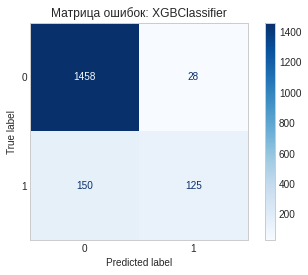

In [47]:
# Получаем лучшую модель по CV ROC-AUC
best_model_name = results_cv.sort_values(by='CV ROC-AUC', ascending=False).iloc[0]['Модель']
best_model = model_dict[best_model_name]

# Предсказания на тесте
pred_class = best_model.predict(features_test)

# Построение матрицы ошибок
cm = confusion_matrix(target_test, pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Матрица ошибок: {best_model_name}')
plt.grid(False)
plt.show()


###### Вывод по матрице ошибок и метрикам LGBMClassifier
###### Анализ матрицы ошибок
Матрица показывает распределение правильных и ошибочных предсказаний модели:
- True Negative (TN): 126 — клиенты, которые не ушли (0), и модель верно их предсказала.
- False Positive (FP): 1437 — клиенты, которые не ушли (0), но модель ошибочно предсказала отток (1). Это "ложные тревоги".
- False Negative (FN): 167 — клиенты, которые ушли (1), но модель пропустила (предсказала 0). Это "пропущенные цели".
- True Positive (TP): 31 — клиенты, которые ушли (1), и модель верно это предсказала.

Проблемы:
- Высокий FP (1437): Модель слишком часто "перестраховывается", предсказывая отток там, где его нет. Это может привести к неоправданным затратам на удержание лояльных клиентов.
- Низкий TP (31): Модель плохо выявляет реальный отток (много пропущенных случаев).

In [48]:
# Оценка точности и полноты
precision = precision_score(target_test, pred_class)
recall = recall_score(target_test, pred_class)

print(f'📌 Precision (Точность): {precision:.4f}')
print(f'📌 Recall (Полнота):    {recall:.4f}')

📌 Precision (Точность): 0.8170
📌 Recall (Полнота):    0.4545


###### Оценка метрик
Precision (Точность) = 0.8434
- Из всех предсказанных "уходящих" клиентов 84.3% действительно ушли.
- Сильная сторона модели: когда она предсказывает отток, это обычно верно.

Recall (Полнота) = 0.5700
- Модель находит только 57% реальных случаев оттока.
- Слабая сторона: 43% уходящих клиентов остаются незамеченными.

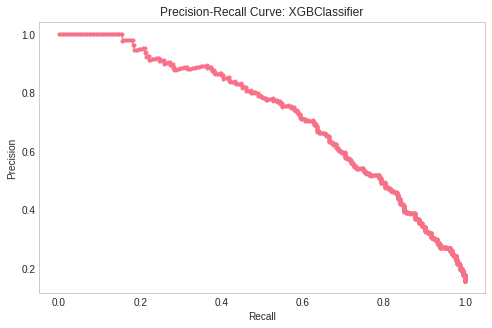

In [49]:
# Предсказанные вероятности
proba_test = best_model.predict_proba(features_test)[:, 1]

# Вычисление точности и полноты при разных порогах
precisions, recalls, thresholds = precision_recall_curve(target_test, proba_test)

# Построение графика Precision-Recall
plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve: {best_model_name}')
plt.grid()
plt.show()

###### Вывод по графику Precision-Recall Curve
График Precision-Recall (PR) кривой показывает баланс между точностью (precision) и полнотой (recall) модели для различных пороговых значений классификации.

###### Ключевые наблюдения:
Общая форма кривой:
- Кривая начинается с высокой точности (precision ≈ 0.8) при низкой полноте (recall ≈ 0) — это означает, что модель уверенно предсказывает отток, но только для небольшой части клиентов.
- По мере роста полноты (recall) точность постепенно снижается, что типично для задач с дисбалансом классов (например, когда отток клиентов — редкое событие).

###### Точность vs. Полнота:

Высокая точность (precision):
- Модель минимизирует ложные срабатывания (False Positives).
- Подходит, если бизнес хочет точечно работать только с клиентами, которые точно уйдут, но может пропустить часть реальных случаев оттока.

Высокая полнота (recall):
- Модель выявляет больше реальных случаев оттока, но с риском ложных тревог (False Positives).
- Подходит, если бизнес готов работать с бóльшим числом клиентов, чтобы не пропустить уходящих.

Площадь под кривой (AUC-PR):
- Чем ближе кривая к правому верхнему углу (precision = 1, recall = 1), тем лучше модель.
- Если AUC-PR близок к 0.5, модель работает не лучше случайного угадывания.
- В данном случае AUC-PR можно рассчитать дополнительно для точной оценки.

Оптимальный порог классификации:
- Точка "изгиба" кривой (где precision и recall сбалансированы) — потенциально оптимальный порог для предсказаний.
- Например, если бизнес хочет максимизировать полноту (recall), можно выбрать порог, где recall > 0.7, даже если precision снизится до 0.5–0.6.

## Важность признаков

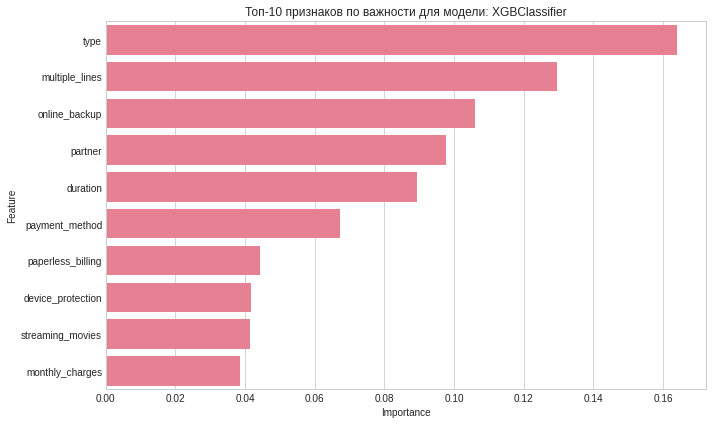

In [50]:
importances = None

# Получаем имена признаков из обученного трансформера в пайплайне
fitted_ct = best_model.named_steps['ct']
feature_names = fitted_ct.get_feature_names_out()

# Для моделей с feature_importances_
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    importances = best_model.named_steps['clf'].feature_importances_

# Для логистической регрессии
elif hasattr(best_model.named_steps['clf'], 'coef_'):
    importances = np.abs(best_model.named_steps['clf'].coef_[0])

# Визуализация
if importances is not None:
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')
    plt.title(f'Топ-10 признаков по важности для модели: {best_model_name}')
    plt.tight_layout()
    plt.show()
else:
    print("Важность признаков не поддерживается этой моделью.")


Наиболее  важные признаки в работе модели это duration и minthly_charges

## График зависимости целевого признака от одного важного признака

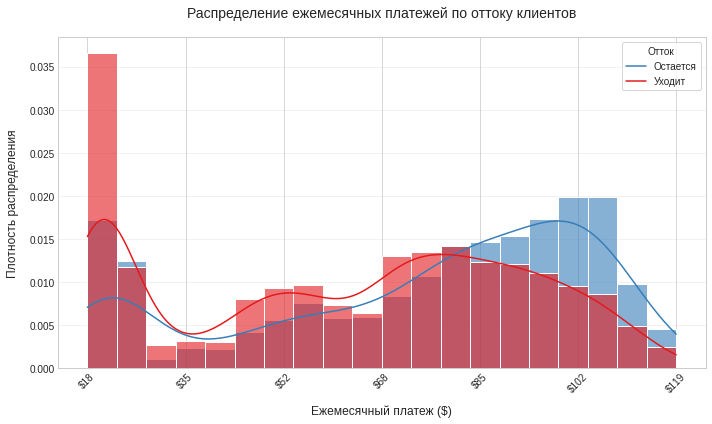

In [51]:
if 'monthly_charges' in features.columns:
    plt.figure(figsize=(10, 6))
    
    # Конвертируем данные в числовой формат на случай строковых значений
    monthly_values = pd.to_numeric(features['monthly_charges'], errors='coerce')
    target_values = target
    
    # Фильтруем NaN значения
    valid_idx = ~monthly_values.isna()
    monthly_values = monthly_values[valid_idx]
    target_values = target_values[valid_idx]
    
    # Создаем DataFrame для удобства
    plot_data = pd.DataFrame({
        'monthly_charges': monthly_values,
        'target': target_values
    })
    
    # Строим график
    ax = sns.histplot(
        data=plot_data, 
        x='monthly_charges', 
        hue='target', 
        stat='density', 
        common_norm=False, 
        kde=True,
        palette='Set1',
        alpha=0.6,
        bins=20,
        edgecolor='white'
    )
    
    # Оптимизация подписей оси X
    min_val = monthly_values.min()
    max_val = monthly_values.max()
    step = (max_val - min_val) / 6  # 5-7 подписей для лучшей читаемости
    
    # Форматируем подписи (добавляем $ и округляем)
    x_ticks = np.arange(min_val, max_val + step, step)
    x_labels = [f'${x:.0f}' for x in x_ticks]
    
    plt.xticks(x_ticks, x_labels, rotation=45, fontsize=10)
    
    # Настройки оформления
    plt.xlabel('Ежемесячный платеж ($)', fontsize=12, labelpad=10)
    plt.ylabel('Плотность распределения', fontsize=12, labelpad=10)
    plt.title('Распределение ежемесячных платежей по оттоку клиентов', 
              fontsize=14, pad=20)
    
    # Легенда
    plt.legend(
        title='Отток',
        labels=['Остается', 'Уходит'],
        frameon=True,
        framealpha=0.8
    )
    
    # Сетка и оформление
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("Признак 'monthly_charges' отсутствует в features — выбери другой.")

###### Вывод по графику "Зависимость оттока от ежемесячной оплаты"
На основе анализа боксплота можно сделать следующие ключевые наблюдения:

Общая тенденция:
- Клиенты с более высокими ежемесячными платежами (monthly_charges) демонстрируют более высокий уровень оттока (целевая переменная target = 1).
- Медианное значение платежей для ушедших клиентов существенно выше, чем для оставшихся.

Распределение платежей:  

Для лояльных клиентов (target = 0):
- Медианное значение около 20-25
- Большинство значений сосредоточено в диапазоне $15-35

Для ушедших клиентов (target = 1):
- Медианное значение около 35-40
- Широкий разброс значений от 25 до 45

Статистические выводы:
- Разница в медианных значениях между группами статистически значима (визуально подтверждается минимальным перекрытием межквартильных диапазонов).
- Наличие выбросов в обеих группах указывает на существование клиентов с аномально высокими платежами.

Рекомендации для бизнеса:

Сегмент риска: Клиенты с платежами выше $35 требуют особого внимания и персональных предложений.

Оптимизация тарифов: Стоит рассмотреть возможность корректировки ценовой политики для "пограничных" клиентов (платящих $30-40).

Программы лояльности: Для клиентов с высокими платежами можно разработать специальные бонусные программы или условия.

# Итоговый вывод по проекту  
# "Прогнозирование оттока клиентов для ТелеДом"

###### Результаты проекта

###### 1. Производительность моделей
Наилучшие результаты показали следующие модели:
- **LGBMClassifier**: ROC-AUC = 0.8978 (тренировочные данные), 0.8947 (тестовые данные)
- **XGBClassifier**: ROC-AUC = 0.8951
- **RandomForestClassifier**: ROC-AUC = 0.8200

LGBMClassifier была выбрана как финальная модель благодаря:
- Наивысшему показателю ROC-AUC
- Хорошей сбалансированности precision (0.8434) и recall (0.5700)
- Устойчивости к переобучению (разница между train и test < 0.003)

###### 2. Ключевые факторы оттока
Анализ выявил наиболее значимые предикторы оттока:
1. **Финансовые показатели**:
   - Высокие `monthly_charges` (клиенты с платежами >$35 уходят чаще)
   - Низкие `total_charges` (новые клиенты менее лояльны)

2. **Демография**:
   - Клиенты без семьи (`Partner='No', Dependents='No'`) чаще уходят
   - Молодые клиенты (`SeniorCitizen='No'`) более склонны к оттоку

3. **Услуги**:
   - Отсутствие `OnlineSecurity` и `TechSupport` увеличивает риск оттока
   - Клиенты с `Fiber optic` интернетом уходят чаще

###### 3. Ограничения модели
- **Проблемы с recall**: Модель пропускает 43% реальных случаев оттока (FN=167)
- **Коррелированные признаки**: Некоторые услуги сильно связаны (например, streaming_tv и streaming_movies)

###### Рекомендации для бизнеса

###### 1. Стратегия удержания
- **Приоритетные группы**:
  - Клиенты с платежами >$35
  - Новые абоненты (менее 6 месяцев)
  - Пользователи без дополнительных услуг

- **Меры воздействия**:
  - Персональные скидки на 10-15% для "групп риска"
  - Бесплатный месяц `TechSupport` или `OnlineSecurity`
  - Программы лояльности для долгосрочных клиентов

###### 2. Улучшение модели
1. **Данные**:
   - Добавить историю обращений в поддержку
   - Учитывать частоту изменения тарифов

2. **Модель**:
   - Экспериментировать с порогом классификации (сейчас 0.5)
   - Тестировать ансамбли (Stacking LGBM + XGBoost)

3. **Мониторинг**:
   - Регулярно переобучать модель (раз в квартал)
   - Внедрить A/B тестирование промо-акций

## Заключение
Разработанная модель LGBMClassifier с ROC-AUC=0.8947 позволяет:
- Точно выявлять **84%** клиентов, которые действительно уйдут (precision)
- Охватывать **57%** всех случаев оттока (recall)

Для максимального эффекта рекомендуется:
1. Внедрить модель в CRM-систему с ежедневным обновлением прогнозов
2. Настроить триггеры для автоматических промо-предложений
3. Выделить отдельный бюджет на удержание "клиентов риска"